In [ ]:
# raw linear regression
nepoh = 1000
lr = 0.001
for i in range(nepoh):
    z = (x.mm(w) + b - y)**2
    loss = z.sum()
    print(loss)
    loss.backward()
    
    w.data = w.data -  w.grad.data*lr
    b.data = b.data -  b.grad.data*lr
    w.grad.data.zero_()
    b.grad.data.zero_()

In [1]:
# Factor Machine Data
import torch,pdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris,fetch_kddcup99,make_classification
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler,LabelEncoder,LabelBinarizer,Binarizer
from sklearn.linear_model import LogisticRegression,stochastic_gradient
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier 
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
import xgboost as xgt

xdata,ydata = make_classification(n_samples=10000, n_features=5, n_classes=2, random_state=None)

coef  = np.array([0.0,0.0,0.0, 0.0,0.0])
ydata = np.matmul(xdata,coef) + xdata[:,1]*xdata[:,2] + xdata[:,2] *xdata[:,3] + xdata[:,1] *xdata[:,3]
ydata = (ydata > np.median(ydata)).astype(np.int)
print(ydata.sum())

/home/zhangruibin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


5000


In [2]:
# DataSet
import torch.utils.data as data
class MyDataset(data.Dataset):
    def __init__(self,  data, labels):
        self.Xdata   = data
        self.labels = labels

    def __getitem__(self, index):#返回的是tensor
        item, target = self.Xdata[index], self.labels[index]
        return item, target

    def __len__(self):
        return self.Xdata.shape[0]

In [3]:
# plot func
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
np.set_printoptions(precision=2)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    plt.figure()
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def plot_roc(ytrue, yprob):
    mean_fpr = np.linspace(0, 1, 100)

    i = 0

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(ytrue, yprob[:, 1])


    roc_auc = metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, alpha=0.3,color='r',
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='b',
             label='Chance', alpha=.8)

    

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


In [4]:
# FM Model
from torch.nn.functional import logsigmoid
from torch import sigmoid,log,diag
from sklearn.base import BaseEstimator,ClassifierMixin
import numpy as np
class TorsorLogisticRegression():
    """
     Logistic Regression classifier implemented by Pytorch
    
    """
    def __init__(self, penalty='l2', C=1.0, lr=0.01, epoch=10000, stop_thod=0.0001, verbose=False):
        self.C = C
        self.penalty = penalty
        self.epoch = epoch
        self.stop_thod = stop_thod
        self.lr = lr
        self.verbose = verbose
    def fit(self, X, y):
        Xt = torch.from_numpy(X.astype(np.float32))
        yt = torch.from_numpy(y.astype(np.float32))
        self.w  = torch.randn(Xt.shape[1],1,requires_grad=True)
        self.b  = torch.zeros(1,requires_grad=True)
        Ns = len(X)
        loglosslast = 0
        print(Xt.dtype, self.w.dtype)
        for epoch_id in  range(self.epoch):

            z = sigmoid(Xt.mm(self.w) + self.b).reshape(-1)
            loglosstensor = -( yt*log(z) + (1-yt)*log(1 - z))
            logloss = loglosstensor.mean()
            
            logloss.backward()
            
            self.w.data = self.w.data -  self.w.grad.data*self.lr
            self.b.data = self.b.data -  self.b.grad.data*self.lr
            
            loglossFloat = logloss.data.numpy()
            
            if abs(loglossFloat - loglosslast)/loglossFloat < self.stop_thod:
                #break
                pass
            else:
                loglosslast = loglossFloat
            
            if epoch_id % int(self.epoch/5) ==0 and self.verbose:
                print('epoch = {0}, loss = {1} '.format(epoch_id, loglossFloat))
                dfout = pd.DataFrame(columns = ['w','dw','w-lr*dw']) 
                dfout['w-lr*dw'] = self.w.data.numpy().reshape(-1)
                dfout.dw = self.w.grad.data.numpy().reshape(-1)
                dfout.w = dfout['w-lr*dw'] + self.lr*dfout.dw
                #print(dfout)
            
            self.w.grad.data.zero_(),self.b.grad.data.zero_()
            
    def predict_proba(self, X):
        Xt = torch.from_numpy(X.astype(np.float32))
        y_prob = sigmoid(Xt.mm(self.w) + self.b)
        y_prob = y_prob.detach().numpy()
        return y_prob.reshape(-1)
    def predict(self, X):
        
        y_prob = self.predict_proba(X)
        y_pre  = y_prob > 0.5
        return y_pre.astype(int)
class TorsorFactorMachine():
    """
     FactorMachine implemented by Pytorch
    
    """
    def __init__(self, penalty='l2', C=1.0, lr=0.01, batch_size = None, epoch=10000, stop_thod=0.0001, verbose=False):
        self.C = C
        self.penalty = penalty
        self.epoch = epoch
        self.stop_thod = stop_thod
        self.lr = lr
        self.verbose = verbose
        self.batch_size = batch_size
    def fm_matrix(self, X):
        
        S1 = X.mm(self.v)
        S2 = diag(torch.matmul(S1,S1.T)).reshape(-1,1)
        S3 = (X**2).mm(self.v**2)
        phi = self.b + X.mm(self.w) + S2 - S3
        
        return phi
    def fm_vector(self, X):
        S1 = X.mm(self.v)
        S2 = S1*S1
        S3 = (X**2).mm(self.v**2)
        phi = self.b + X.mm(self.w) + S2 - S3
        return phi
    def fm(self,X):
        return self.fm_matrix(X) 
    
    def fit(self, X, y):
        Xdata = torch.from_numpy(X.astype(np.float32))
        ydata = torch.from_numpy(y.astype(np.float32))
        self.w  = torch.randn(Xdata.shape[1],1,requires_grad=True)
        self.v  = torch.randn(Xdata.shape[1],1,requires_grad=True)
        self.b  = torch.randn(1,requires_grad=True)

        loglosslast = 0
        
        dataLoader = torch.utils.data.DataLoader(MyDataset(Xdata, ydata), batch_size=self.batch_size, shuffle=True)
        
        for epoch_id in  range(self.epoch):            
            for i, (Xt, yt) in enumerate( dataLoader):
                z = self.fm(Xt)
                phi = torch.clamp(sigmoid(z),0.001,0.999).reshape(yt.shape)
                logloss = -torch.mean(( yt*log(phi) + (1-yt)*log(1 - phi)))
                logloss.backward()
                #pdb.set_trace()
                self.w.data = self.w.data -  self.w.grad.data*self.lr
                self.v.data = self.v.data -  self.v.grad.data*self.lr
                self.b.data = self.b.data -  self.b.grad.data*self.lr
                self.w.grad.data.zero_(),self.b.grad.data.zero_()

            loglossFloat = logloss.data.numpy()
            if np.isnan(loglossFloat):
                print('epoch = ', epoch_id, 'logloss = ', loglossFloat )
                print(phi,z)
                break
            if abs(loglossFloat - loglosslast)/loglossFloat < self.stop_thod:
                #break
                pass
            else:
                loglosslast = loglossFloat
                
            if epoch_id % int(self.epoch/10) ==0 and self.verbose:
                    print('epoch = {0}, loss = {1} '.format(epoch_id, loglossFloat))
    def predict_proba(self, X):
        Xt = torch.from_numpy(X.astype(np.float32))
        y_prob = sigmoid( self.fm(Xt) )
        y_prob = y_prob.detach().numpy()
        return y_prob.reshape(-1)
    def predict(self, X):
        
        y_prob = self.predict_proba(X)
        y_pre  = y_prob > 0.5
        return y_pre.astype(int)

epoch = 0, loss = 3.695995330810547 
epoch = 500, loss = 0.8141794204711914 
epoch = 1000, loss = 0.6137745380401611 
epoch = 1500, loss = 0.5503057837486267 
epoch = 2000, loss = 0.32228317856788635 
epoch = 2500, loss = 0.4934259355068207 
epoch = 3000, loss = 0.3408129811286926 
epoch = 3500, loss = 0.36015188694000244 
epoch = 4000, loss = 0.32976222038269043 
epoch = 4500, loss = 0.36015191674232483 
Confusion matrix, without normalization
Confusion matrix, without normalization
[[ 0.05 -0.01  0.01 -0.19 -0.05]]


<Figure size 432x288 with 0 Axes>

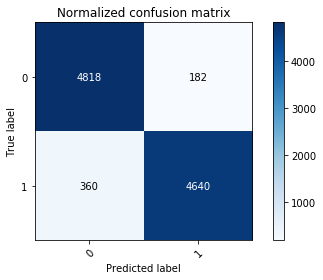

<Figure size 432x288 with 0 Axes>

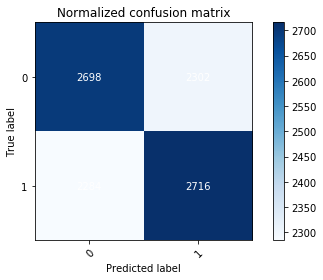

In [6]:
# Factor Machine Run
tfm = TorsorFactorMachine(lr=0.0001,epoch=5000,batch_size = 2500,verbose=True)
tfm.fit(xdata,ydata) # Xd,yd,bd, wd, vd = 
yprob_t = tfm.predict_proba(xdata)
ypre_t = tfm.predict(xdata)
plot_confusion_matrix(ydata, ypre_t,classes=np.array([0,1]), normalize=False,
                      title='Normalized confusion matrix')

clf = LogisticRegression()
clf.fit(xdata,ydata)
yprob_l = clf.predict_proba(xdata)
ypre_l = clf.predict(xdata)
plot_confusion_matrix(ydata, ypre_l,classes=np.array([0,1]), normalize=False,
                      title='Normalized confusion matrix')
print(clf.coef_)
#print(z.shape, yt.shape,Xt.mm(self.v).shape,self.fm(Xt).shape)

In [ ]:
X = torch.tensor([[1,2,3],[4,5,6]],dtype=torch.float32)
y = torch.tensor([4,5],dtype=torch.float32)
w  = torch.ones(X.shape[1],1,requires_grad=True)
v  = torch.ones(X.shape[1],1,requires_grad=True)
b  = torch.ones(1,requires_grad=True)
S1 = X.mm(v)
S2 = (X**2).mm(v**2)
S3 = diag(torch.matmul(S1,S1.T)).reshape(-1,1)
z = b + X.mm(w) + S3-S2
z,z.reshape(y.shape)

In [ ]:
(X**2).mm(v**2)

In [ ]:
# debug
from torch import log,exp,mean
import pandas as pd
import numpy as np
import torch.utils.data as data
xdata,ydata = make_classification(n_samples=100, n_features=5, n_informative=2, n_redundant=2, n_repeated=0, 
                           n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, 
                           hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
coef  = np.array([0.5,0.1, -1.5, 2.1,0.1])
ydata = (np.matmul(xdata,coef) > 0.5).astype(np.int)

num_epochs = 100
num_classes = 2
batch_size = 100
lr = 0.1

class MyDataset(data.Dataset):
    def __init__(self, signal, labels):
        self.signal = signal.reshape([signal.shape[0],signal.shape[1]])
        self.labels = labels.reshape([signal.shape[0]])

    def __getitem__(self, index):#返回的是tensor
        sig, target = self.signal[index], self.labels[index]
        return sig, target

    def __len__(self):
        return len(self.signal)


clf = LogisticRegression()
clf.fit(xdata,ydata)


dfout = pd.DataFrame(columns = ['w','dw','w-lr*dw','coef_'])
X = xdata
y = ydata
Xall = torch.from_numpy(X.astype(np.float32))
yall = torch.from_numpy(y.astype(np.float32))
w  = torch.randn(Xall.shape[1],1,requires_grad=True)
b  = torch.zeros(1,requires_grad=True)

train_loader = torch.utils.data.DataLoader(MyDataset(Xall, yall), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for i, (Xt, yt) in enumerate( train_loader):
        yout = sigmoid(Xt.mm(w) + b).reshape(-1)
        #yout = 1/(1 + exp(-(Xt.mm(w) + b))).reshape(-1)
        loglosstensor = -( yt*log(yout) + (1-yt)*log(1 - yout))
        logloss = mean(loglosstensor)
        logloss.backward()

        w.data = w.data - w.grad.data * lr
        b.data = b.data - b.grad.data * lr

        w.grad.data.zero_(),b.grad.data.zero_(),
    
    print(logloss.data)
    
yprob_t = sigmoid(Xall.mm(w) + b).data.reshape(-1).numpy()
ypre_t =  (yprob_t > 0.5 ).astype(np.int)
plot_confusion_matrix(ydata, ypre_t,classes=np.array([0,1]), normalize=False,
                      title='Normalized confusion matrix')

In [279]:
def fm_matrix(X):
    S1 = X.mm(v)
    S2 = diag(torch.matmul(S1,S1.T)).reshape(-1,1)
    S3 = (X**2).mm(v**2)
    phi = b + X.mm(w) + S2 - S3
    return phi
def fm_vector(X):
    S1 = X.mm(v)
    S2 = S1*S1
    S3 = (X**2).mm(v**2)
    phi = b + X.mm(w) + S2 - S3
    return phi

X = torch.tensor([[1.0,2,3],[4,5,6.0]])
w = torch.tensor([1.0,2,3]).reshape(3,1)
v = torch.tensor([2.0,2,3]).reshape(3,1)
b = torch.tensor([0.0])

fm_matrix(X),fm_vector(X)


(tensor([[138.],
         [840.]]), tensor([[138.],
         [840.]]))

In [25]:
logloss

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])